In [1]:
cd ..

/home/max/Documents/mgr


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.generate import load_dataset
from src.ontofun import *
from src.syntax import *
from src.utils import *
from src.vis import *
from src.reasoneur import *

seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()

In [3]:
class NNExprEncoder(nn.Module):
    def __init__(self, *, expr_size, n_concepts, n_roles):
        super().__init__()
        self.n_concepts = n_concepts
        self.n_roles = n_roles
        self.expr_size = expr_size
        self.top_concept = nn.Parameter(T.zeros((1, expr_size)))
        self.bot_concept = nn.Parameter(T.zeros((1, expr_size)))
        self.concepts = nn.Parameter(T.zeros((n_concepts, expr_size)))
        self.roles = nn.ModuleList([nn.Linear(expr_size, expr_size) for _ in range(n_roles)])
        self.and_nn = nn.Linear(2*expr_size + expr_size**2, expr_size)
        self.not_nn = nn.Linear(expr_size, expr_size)
        for x in [self.concepts, self.top_concept, self.bot_concept]:
            nn.init.xavier_normal_(x)
        
    @classmethod
    def from_onto(cls, onto, *args, **kwargs):
        return cls(n_concepts=onto.n_concepts, n_roles=onto.n_roles, *args, **kwargs)
    
class RelaxedReasoner(nn.Module):
    def __init__(self, *, expr_size, hidden_size=128):
        super().__init__()
        self.hidden_size, self.expr_size = hidden_size, expr_size
        self.sub_nn = nn.Sequential(
            nn.Linear(2*expr_size + expr_size**2, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, 1),
        )
            
    def encode(self, axiom, embeddings):
        def rec(expr):
            if isinstance(expr, int):
                return T.tanh(embeddings.concepts[expr])
            
            if expr is TOP:
                return T.tanh(embeddings.top_concept[0])
            
            if expr is BOT:
                return T.tanh(embeddings.bot_concept[0])

            if expr[0] == SUB:
                c = rec(expr[1])
                d = rec(expr[2])
                cxd = T.outer(c, d).view(-1)
                return self.sub_nn(T.cat((c, d, cxd)))
            
            if expr[0] == AND:
                c = rec(expr[1])
                d = rec(expr[2])
                cxd = T.outer(c, d).view(-1)
                return T.tanh(embeddings.and_nn(T.cat((c, d, cxd))))
            
            if expr[0] == ANY:
                c = rec(expr[2])
                r = embeddings.roles[expr[1]]
                return T.tanh(r(c))
            
            if expr[0] == NOT:
                c = rec(expr[1])
                return T.tanh(embeddings.not_nn(c))

            assert False, f'Unsupported expression {expr}. Did you convert it to core form?'
            
        return rec(axiom)
    
    def classify_batch(self, axioms, embeddings):
        return T.vstack([self.encode(axiom, emb) for axiom, emb in zip(axioms, embeddings)])
    
    def classify(self, axiom, emb):
        return self.classify_batch([axiom], [emb])[0].item()
    
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

Reasoner = RelaxedReasoner
Encoder = NNExprEncoder
Optimizer = T.optim.AdamW
expr_size = 10

hidden_size = 16
lr_reasoner = 0.0001
lr_encoder = 0.0002
lr_encoder_test = lr_encoder
epoch_count = 15 + 1
test_epoch_count = 10 + 1
batch_size = 32

T.manual_seed(seed)
trained_reasoner = Reasoner(expr_size=expr_size, hidden_size=hidden_size)
reasoner_optim = Optimizer(trained_reasoner.parameters(), lr=lr_reasoner)

encoders = [Encoder.from_onto(onto, expr_size=expr_size) for onto in train_onto]
optimizers = [Optimizer(encoder.parameters(), lr=lr_encoder) for encoder in encoders]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

history_tr, history_vl = [], []
train(data_tr, data_vl, (trained_reasoner, reasoner_optim), (encoders, optimizers), history_tr, history_vl,
      epoch_count=epoch_count, batch_size=batch_size)

created reasoner with 1953 parameters
created 40 encoders with 2670 parameters each
train epoch 01/16 | batch 2000/2000 | loss 0.7133 | val loss 0.7127 | acc 0.2521 | f1 0.3779 | prec 0.2355 | recall 0.9548 | roc auc 0.5119 | elapsed 14.03s
train epoch 02/16 | batch 2000/2000 | loss 0.6056 | val loss 0.5450 | acc 0.7627 | f1 0.0058 | prec 0.8462 | recall 0.0029 | roc auc 0.5595 | elapsed 58.09s
train epoch 03/16 | batch 2000/2000 | loss 0.4964 | val loss 0.4680 | acc 0.7906 | f1 0.2263 | prec 0.9333 | recall 0.1287 | roc auc 0.7593 | elapsed 58.49s
train epoch 04/16 | batch 2000/2000 | loss 0.3877 | val loss 0.3780 | acc 0.8543 | f1 0.6009 | prec 0.8624 | recall 0.4611 | roc auc 0.8392 | elapsed 58.40s
train epoch 05/16 | batch 2000/2000 | loss 0.2981 | val loss 0.3277 | acc 0.8835 | f1 0.7112 | prec 0.8667 | recall 0.6030 | roc auc 0.8712 | elapsed 60.04s
train epoch 06/16 | batch 2000/2000 | loss 0.2431 | val loss 0.2998 | acc 0.8983 | f1 0.7552 | prec 0.8838 | recall 0.6592 | roc au

In [4]:
## --- TESTING
test_history, test_history_by_onto = [], []
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = Reasoner(expr_size=expr_size, hidden_size=hidden_size)
for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    test_encoders = [Encoder.from_onto(onto, expr_size=expr_size) for onto in test_onto]
    test_optimizers = [Optimizer(encoder.parameters(), lr=lr_encoder_test) for encoder in test_encoders]
    test(test_data=data_te, test_onto=test_onto, reasoner=reasoner, reasoner_name=reasoner_name,
        encoders=test_encoders, optimizers=test_optimizers, test_hist=test_history,
        test_hist_by_onto=test_history_by_onto,
        epoch_count=test_epoch_count, batch_size=batch_size)
    trained_test_encoders[reasoner_name] = test_encoders

trained reasoner
test epoch 01/11 | batch 1250/1250 | test loss 1.3413 | acc 0.6144 | f1 0.2738 | prec 0.2413 | recall 0.3164 | roc auc 0.4951 | elapsed 10.66s
test epoch 02/11 | batch 1250/1250 | test loss 0.6369 | acc 0.7379 | f1 0.3111 | prec 0.3925 | recall 0.2576 | roc auc 0.6581 | elapsed 27.02s
test epoch 03/11 | batch 1250/1250 | test loss 0.5020 | acc 0.7917 | f1 0.4433 | prec 0.5740 | recall 0.3611 | roc auc 0.7581 | elapsed 27.18s
test epoch 04/11 | batch 1250/1250 | test loss 0.4002 | acc 0.8403 | f1 0.5777 | prec 0.7356 | recall 0.4756 | roc auc 0.8385 | elapsed 26.70s
test epoch 05/11 | batch 1250/1250 | test loss 0.3163 | acc 0.8837 | f1 0.7060 | prec 0.8420 | recall 0.6078 | roc auc 0.8969 | elapsed 26.59s
test epoch 06/11 | batch 1250/1250 | test loss 0.2509 | acc 0.9125 | f1 0.7845 | prec 0.9037 | recall 0.6931 | roc auc 0.9331 | elapsed 27.10s
test epoch 07/11 | batch 1250/1250 | test loss 0.2048 | acc 0.9282 | f1 0.8256 | prec 0.9333 | recall 0.7402 | roc auc 0.9542

In [5]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te, detach=True)
    _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te, detach=True)

In [6]:
df_tr = pd.DataFrame(history_tr)
df_vl = pd.DataFrame(history_vl)
test_history_by_onto = pd.DataFrame(test_history_by_onto)
test_history = pd.DataFrame(test_history)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good.reshape(-1), Y_te_rand=Y_te_rand.reshape(-1)))

local/out/exp/20220622T074316


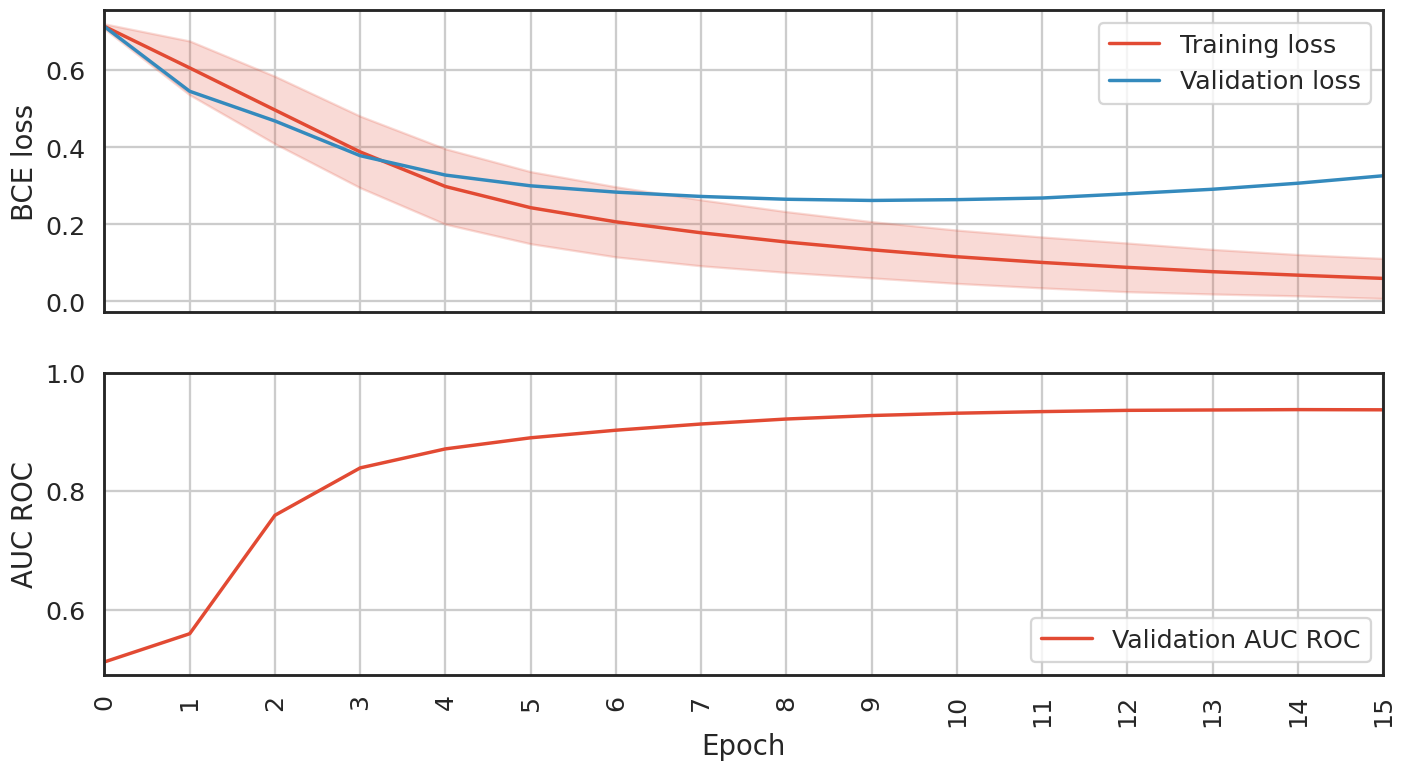

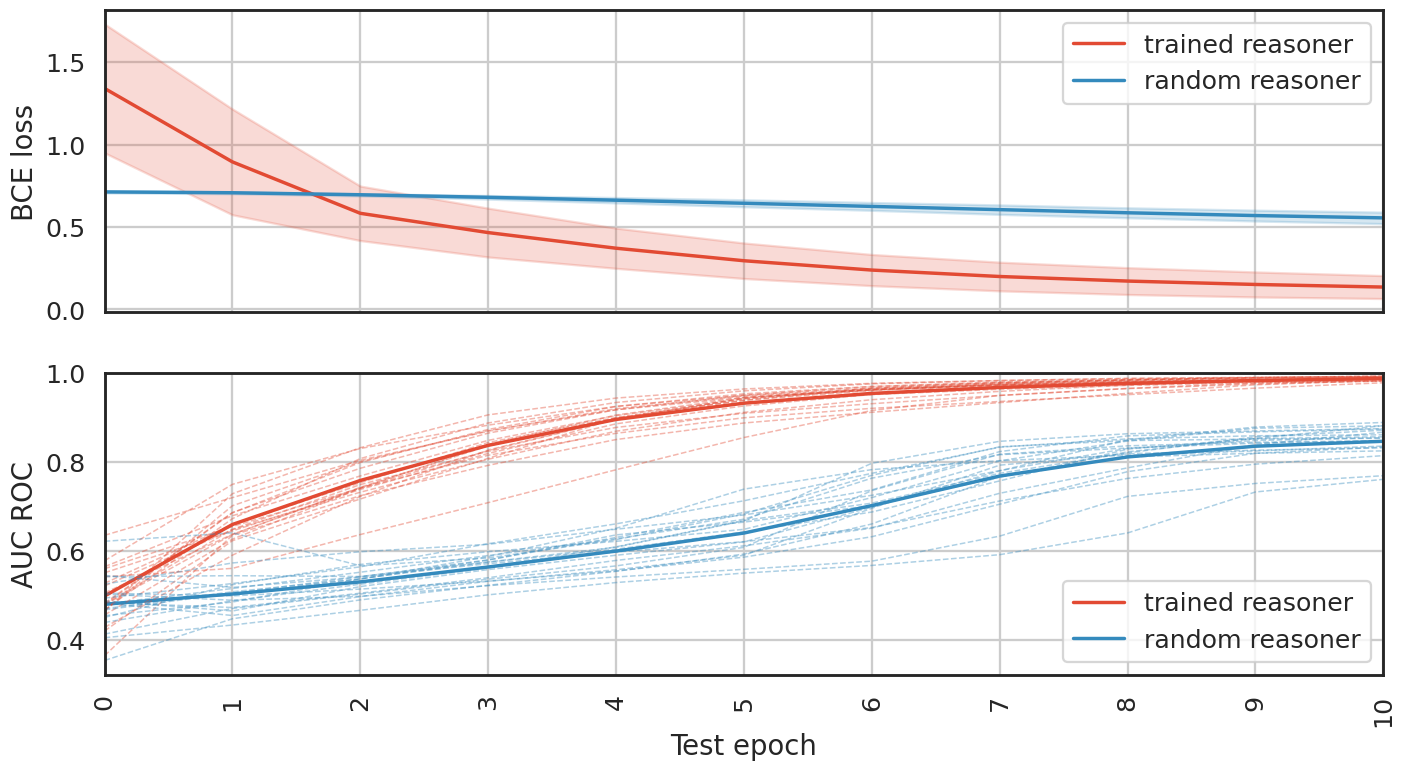

             mean       std     micro
acc      0.957225  0.007433  0.957225
prec     0.971509  0.019126  0.970670
recall   0.838580  0.025920  0.839156
f1       0.899888  0.017261  0.900134
auc_roc  0.986702  0.004233  0.986758
ap       0.969925  0.008801  0.969845
             mean       std     micro
acc      0.842300  0.037284  0.842300
prec     0.654452  0.077328  0.641295
recall   0.713109  0.060240  0.711503
f1       0.677697  0.046473  0.674577
auc_roc  0.846127  0.034381  0.841424
ap       0.792243  0.038908  0.787922


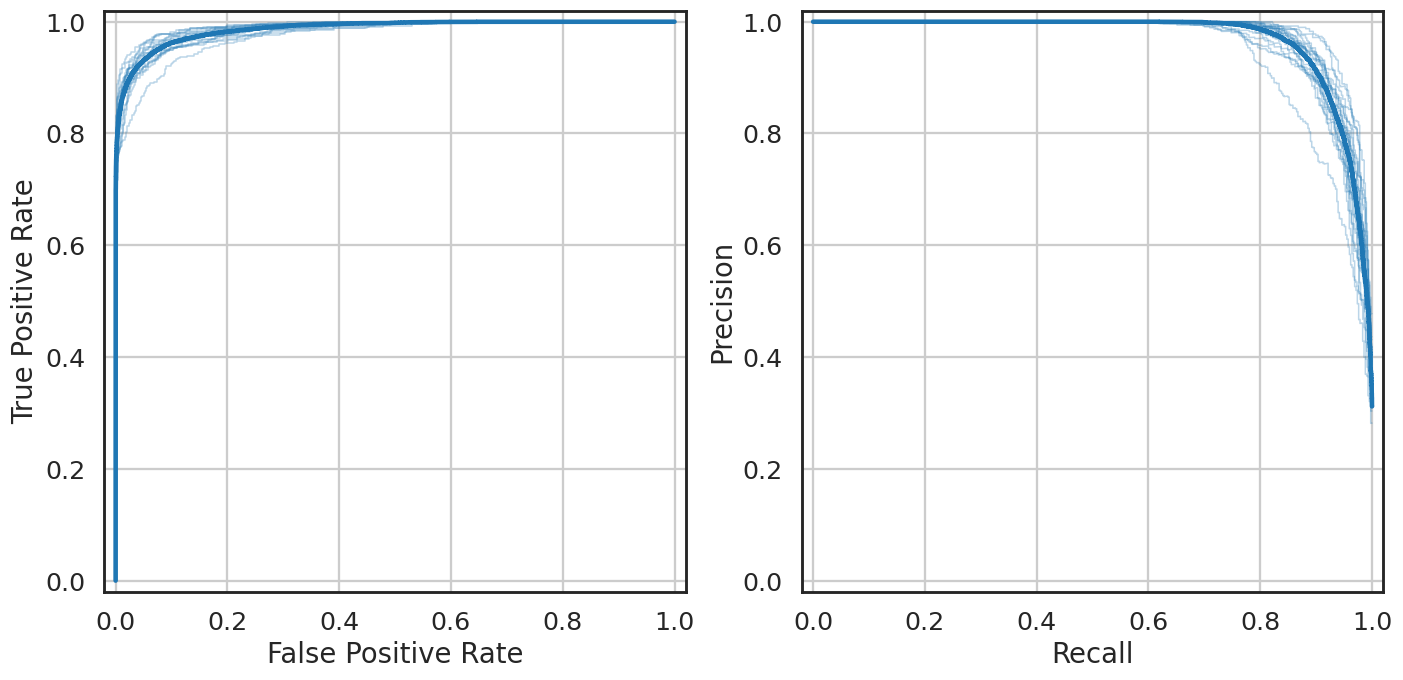

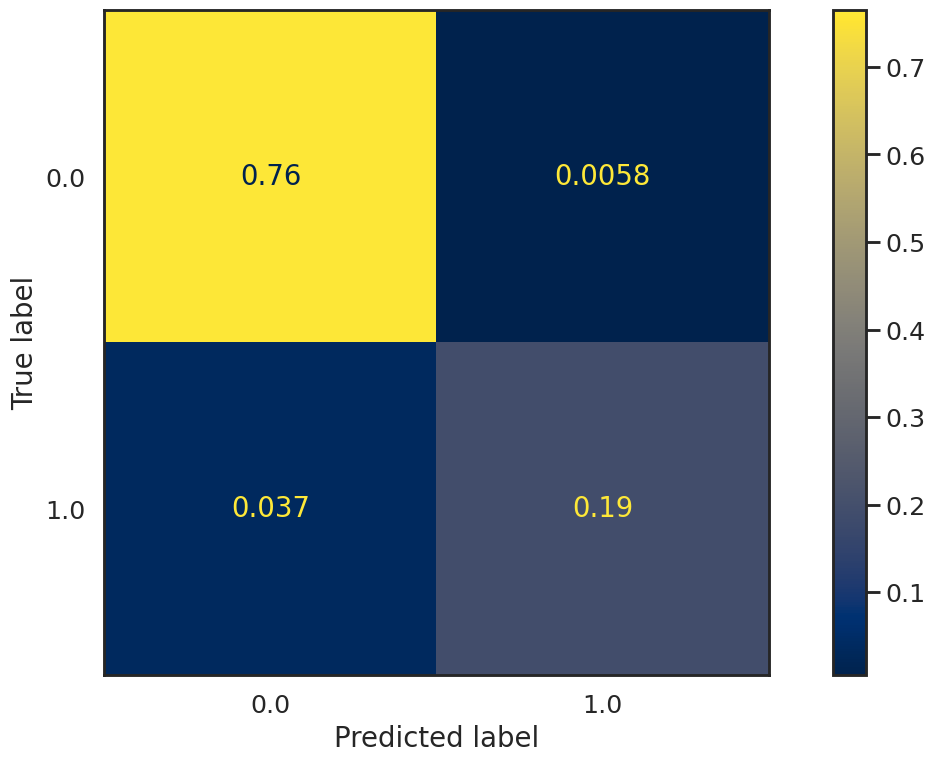

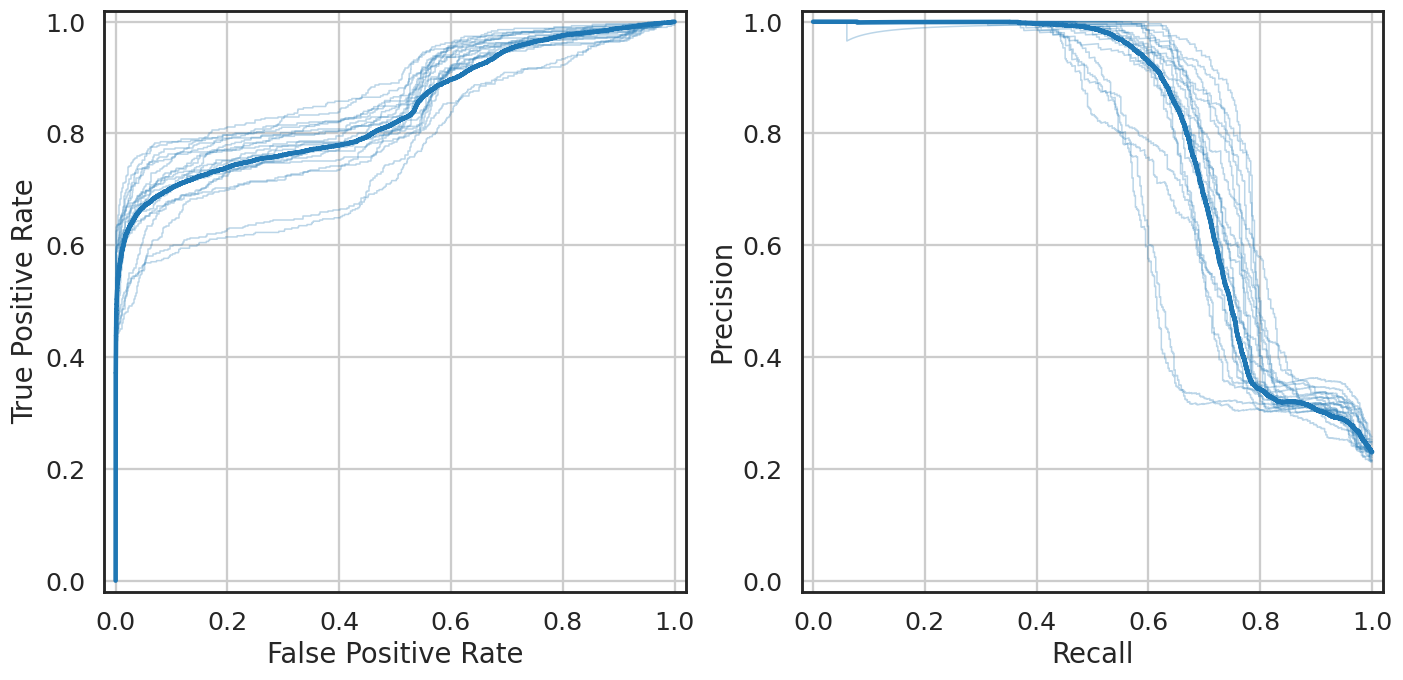

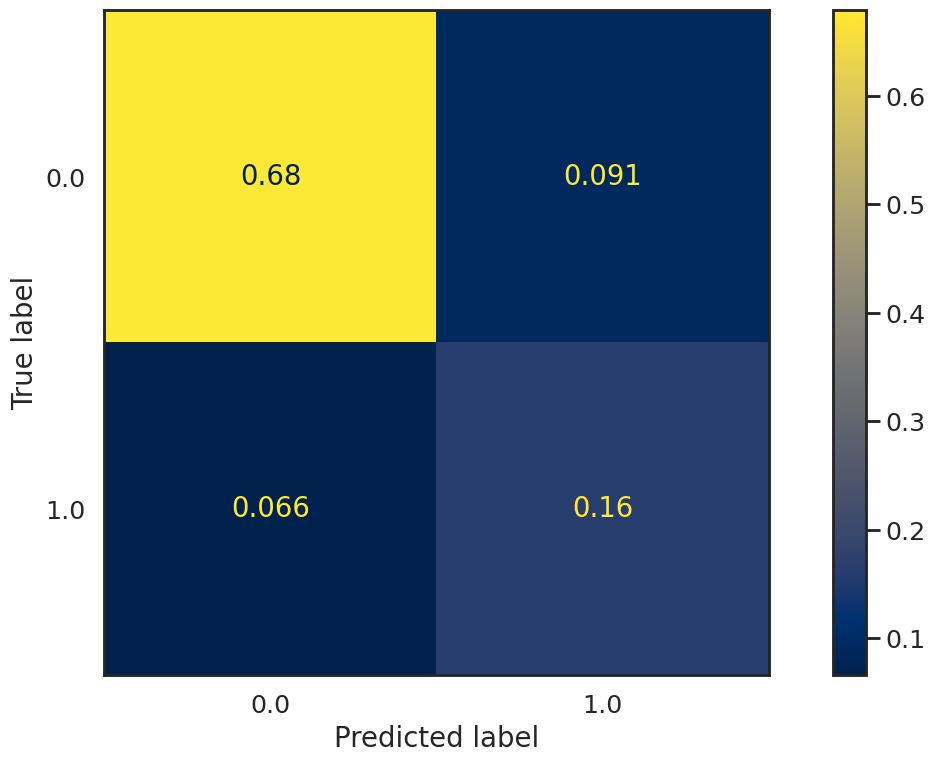

In [7]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, Y_te_good, idx_te, save=base+'/%-trained'))
print(report(test_onto, y_te, Y_te_rand, idx_te, save=base+'/%-random'))